# Data Preparation

In [54]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import seaborn as sns
import pandas as pd

# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_file = 'bert_less_layers.keras'

Keras = 3.8.0
Num GPUs Available:  1


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset

In [56]:
import os
import pandas as pd

# Define the directory for saving the combined dataset
base_dir = "/content/drive/My Drive/SIT_Capstone/"
csv_file = os.path.join(base_dir, "combined_convo_dataset.csv")

# Define the paths for your datasets
splits = {
    'train': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_train.csv',
    'test': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_test.csv',
    'multi_agent_train': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_train.csv',
    'multi_agent_test': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_test.csv',
    'single_agent_train': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_train.csv',
    'single_agent_test': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_test.csv'
}
gen_convo_path = "hf://datasets/BothBosu/Scammer-Conversation/gen_conver_noIdentifier_1000.csv"

# Load datasets
try:
    train_df = pd.read_csv(splits['train'])
    test_df = pd.read_csv(splits['test'])
    multi_agent_train_df = pd.read_csv(splits['multi_agent_train'])
    multi_agent_test_df = pd.read_csv(splits['multi_agent_test'])
    single_agent_train_df = pd.read_csv(splits['single_agent_train'])
    single_agent_test_df = pd.read_csv(splits['single_agent_test'])
    gen_convo_df = pd.read_csv(gen_convo_path)

    # Standardize column naming
    for df in [train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df]:
        # Rename 'dialogue' or 'conversation' to 'conversation'
        if 'dialogue' in df.columns:
            df.rename(columns={'dialogue': 'conversation'}, inplace=True)
        elif 'conversation' not in df.columns:
            raise ValueError("Missing both 'dialogue' and 'conversation' columns in one of the datasets.")

        # Rename 'labels' to 'label' if present
        if 'labels' in df.columns:
            df.rename(columns={'labels': 'label'}, inplace=True)

    # Combine datasets into one
    combined_df = pd.concat([train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df], ignore_index=True)

    # Save the combined dataset
    combined_df.to_csv(csv_file, index=False)
    print("Combined dataset saved successfully!")

    # Print details
    print("First 5 rows of the combined dataset:")
    print(combined_df.head())

    # Total count of rows in the combined dataset
    total_count = len(combined_df)
    print(f"\nTotal number of rows in the combined dataset: {total_count}")

    # Count of each label
    if 'label' in combined_df.columns:
        label_counts = combined_df['label'].value_counts()
        print("Count of each label:")
        print(label_counts)
    else:
        print("Warning: No 'label' column found in the combined dataset.")

except Exception as e:
    print(f"An error occurred: {e}")

Combined dataset saved successfully!
First 5 rows of the combined dataset:
                                        conversation type  label personality
0  caller: Hello, is this John? receiver: Yes, it...  ssn      1         NaN
1  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
2  caller: Hello, is this Mr. Johnson? receiver: ...  ssn      1         NaN
3  caller: Hello, is this John? receiver: Yeah, t...  ssn      1         NaN
4  caller: Hello, this is Officer Johnson from th...  ssn      1         NaN

Total number of rows in the combined dataset: 5800
Count of each label:
label
1    2924
0    2876
Name: count, dtype: int64


# Data Cleaning

In [57]:
# Remove duplicates
combined_df = combined_df.drop_duplicates()
print(f"Total rows after removing duplicates: {len(combined_df)}")

# Print new label_counts
label_counts = combined_df['label'].value_counts()
print(label_counts)

Total rows after removing duplicates: 5556
label
0    2839
1    2717
Name: count, dtype: int64


# Ratio of Normal to Fraud data Distribution

Ratio of normal to fraud: 0.91
Normal label percentage: 47.60%
Fraud label percentage: 52.40%


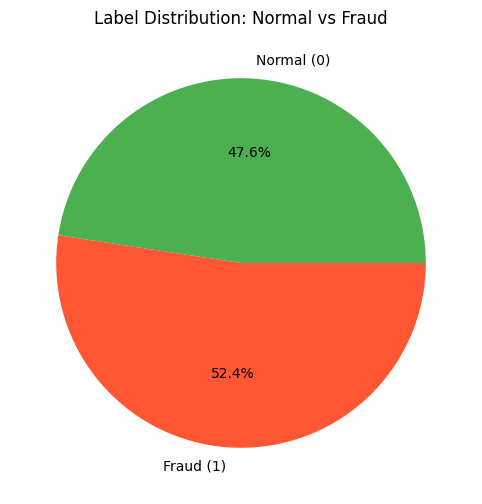

In [58]:
# Count the occurrences of each label dynamically
label_counts = df['label'].value_counts().to_dict()

# Total number of entries
total_count = sum(label_counts.values())

# Extract counts for fraud (1) and normal (0) labels
normal_count = label_counts.get(0, 0)
fraud_count = label_counts.get(1, 0)

# Calculate the ratio of normal to fraud
if fraud_count > 0:  # Avoid division by zero
    ratio = normal_count / fraud_count
else:
    ratio = float('inf')  # If no fraud cases, set ratio to infinity

# Print the ratio and percentages
print(f"Ratio of normal to fraud: {ratio:.2f}")
print(f"Normal label percentage: {(normal_count / total_count) * 100:.2f}%")
print(f"Fraud label percentage: {(fraud_count / total_count) * 100:.2f}%")

# Visualize the label distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    [normal_count, fraud_count],
    labels=['Normal (0)', 'Fraud (1)'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733']
)
plt.title('Label Distribution: Normal vs Fraud')
plt.show()

# To check for optimal max length for tokenization

In [ ]:
from sklearn.model_selection import train_test_split

# Select only the required columns
X = combined_df['conversation']  # Features
y = combined_df['label']         # Target

# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

avg_length = X.apply(lambda x: len(x.split())).mean()
print(f"Average text length: {avg_length}")

print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

Average text length: 316.81011519078476
Training label distribution:
label
0    2295
1    2149
Name: count, dtype: int64
Testing label distribution:
label
1    568
0    544
Name: count, dtype: int64


# Model Building

In [ ]:
from transformers import BertTokenizer
import torch

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Dynamically set max_length based on average text length
max_length = int(avg_length * 1.2)  # Set max_length to 120% of average length (for some buffer)

# Tokenize the text data for BERT
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize training and testing data with dynamic max_length
print(f"Using max_length: {max_length}")
train_encodings = tokenize_texts(X_train, tokenizer, max_length=max_length)
print("Tokenizing testing data...")
test_encodings = tokenize_texts(X_test, tokenizer, max_length=max_length)

# Convert labels to torch tensors with float32 data type for binary classification
train_labels = torch.tensor(y_train.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.float32)

# Print the size of each split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Using max_length: 380
Tokenizing testing data...
Training set size: 4444
Testing set size: 1112


# Model Training (Bert)

In [62]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.9 MB/s eta 0:00:00


In [63]:
import optuna
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, AdamW, get_scheduler, BertConfig
from tqdm import tqdm
import torch.nn.functional as F

def objective(trial):
    # Suggest a learning rate between 1e-6 and 1e-3
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-3)

    # Load the existing BERT configuration
    config = BertConfig.from_pretrained("bert-base-uncased")
    config.num_hidden_layers = 6  # Reduce from 12 to 6 layers
    config.num_labels = 1  # Binary classification

    # Load model
    model = BertForSequenceClassification(config).to(device)

    # Define optimizer with trial's suggested learning rate
    optimizer = AdamW(model.parameters(), lr=lr)

    # Define number of epochs
    epochs = 3  # Use a smaller number of epochs for faster tuning

    # Define DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Define scheduler
    num_training_steps = len(train_loader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)
    scheduler = get_scheduler(
        name="linear", optimizer=optimizer,
        num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
    )

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze(-1)
            loss = F.binary_cross_entropy_with_logits(logits, labels.float())
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits.squeeze(-1)
                loss = F.binary_cross_entropy_with_logits(logits, labels.float())
                val_loss += loss.item()

        val_loss /= len(test_loader)

        # Prune trials that are not improving
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss  # Minimize validation loss

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-15 13:17:15,482] A new study created in memory with name: no-name-6c283657-e930-4dc9-b2a0-0d8c66ad8c4c
<ipython-input-63-7699edee85df>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-6, 1e-3)
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3 Training: 100%|██████████| 278/278 [01:31<00:00,  3.05it/s]
[I 2025-03-15 13:22:11,721] Trial 0 finished with value: 0.694792742388589 and parameters: {'lr': 0.0006286475259858797}. Best is trial 0 with value: 0.694792742388589.
Epoch 3 Training: 100%|██████████| 278/278 [01:31

Best Hyperparameters: {'lr': 9.985504728425866e-05}


# Model Architecture

In [64]:
# Print model architecture
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

# Plotting the Learning Curve of the Model

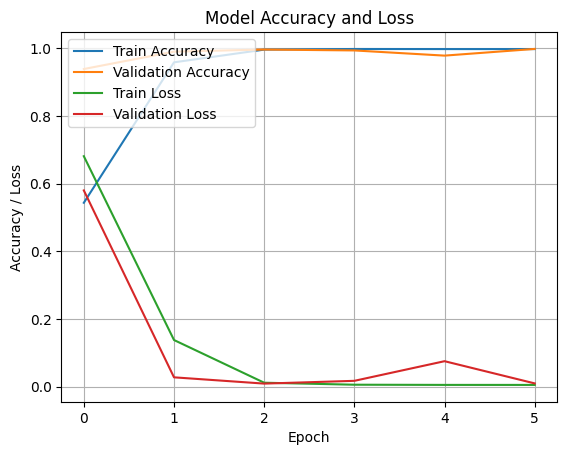

In [65]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot Loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)  # Optional for better readability
plt.show()

# Precision, Recall, F1-Score

In [67]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model.eval()

max_length = int(avg_length * 1.2)  # Set max_length to 120% of average length (for some buffer)

# Prepare the test data
test_encodings = tokenize_texts(X_test, tokenizer, max_length=max_length)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Make sure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Generate classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       544
         1.0       0.99      1.00      1.00       568

    accuracy                           1.00      1112
   macro avg       1.00      1.00      1.00      1112
weighted avg       1.00      1.00      1.00      1112



# Confusion Matrix

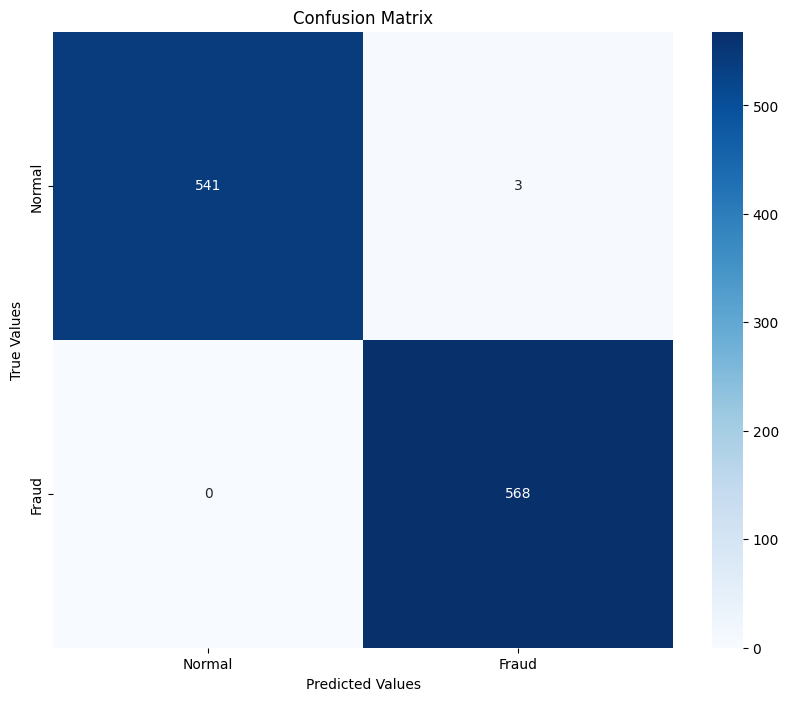

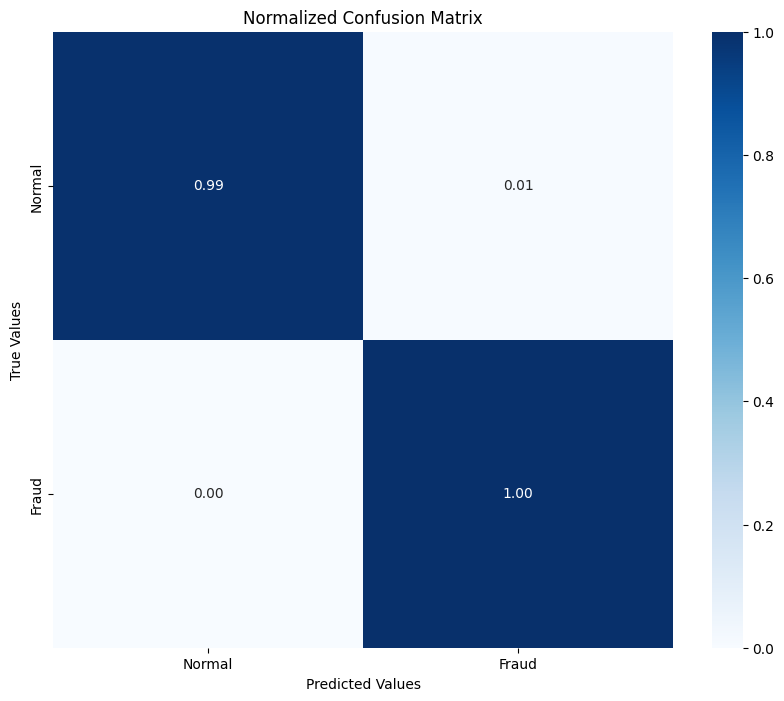

DSC: 0.9973005668324142, Sensitivity: 0.9972426470588236, Specificity: 0.9972426470588236, Accuracy: 0.9973021582733813


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def calculate_metrics(y_true, y_pred, classes=['Normal', 'Fraud']):
    """
    Calculate and display various evaluation metrics based on true and predicted labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - classes: List of class labels (default: ['Normal', 'Fraud']).

    Returns:
    - dsc: Dice similarity coefficient (mean across classes).
    - sensitivity: Mean sensitivity across classes.
    - specificity: Mean specificity across classes.
    - accuracy: Overall accuracy.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate the Dice similarity coefficient (DSC) for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])

    # Calculate the sensitivity (recall) for each class and average them
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])

    # Calculate the specificity for each class and average them
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Calculate the overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print the evaluation metrics
    print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

    return dsc, sensitivity, specificity, accuracy

# Make sure model is in evaluation mode
model.eval()

max_length = int(avg_length * 1.2)  # Set max_length to 120% of average length (for some buffer)

# Prepare the test data (tokenized input data for PyTorch)
test_encodings = tokenize_texts(X_test, tokenizer, max_length=max_length)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Ensure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Calculate metrics
dsc, sensitivity, specificity, accuracy = calculate_metrics(true_labels, predictions)


In [ ]:
!pip install transformers torch gradio

Ignore receiver message

In [ ]:
import gradio as gr

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load model function
def load_model(model_path="best_bert_model.pt"):
    config = BertConfig.from_pretrained("bert-base-uncased")
    config.num_hidden_layers = 6  # Ensure architecture matches trained model
    config.num_labels = 1  # Binary classification
    model = BertForSequenceClassification(config)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load model
model = load_model()

# Function to classify caller messages
def classify_caller_message(caller_messages, scam_detected=False):
    """
    Classifies the latest caller message while considering past caller messages only.
    """
    scam_threshold = 0.7 if scam_detected else 0.5  # Increase scam threshold after a scam is found

    if not caller_messages:
        return "No caller messages to analyze.", scam_detected

    # Format conversation history (only caller messages)
    input_text = " ".join([f"Caller: {text}" for text in caller_messages])
    inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)

    # Model inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probability
    prediction = torch.sigmoid(outputs.logits).item()

    # Determine scam classification
    is_scam = prediction > scam_threshold
    response = "🚨 Scam Alert: This message might be a scam!" if is_scam else "✅ Caller message seems safe."

    return response, is_scam  # Return classification & scam detection flag

# Gradio Chat Interface
def chat_interface(speaker, message, conversation_log=[], caller_messages=[], scam_detected=False):
    """
    Handles the chat flow while ensuring only the caller's messages affect scam classification.
    """
    conversation_log.append((speaker, message))  # Append to full log

    if speaker == "caller":
        caller_messages.append(message)  # Only keep caller messages for classification
        response, scam_detected = classify_caller_message(caller_messages, scam_detected)
        conversation_log.append(("System", response))
    else:
        response = "✅ Receiver message recorded (ignored for scam detection)."  # Receiver messages do not affect model
        conversation_log.append(("System", response))

    return conversation_log, caller_messages, scam_detected, ""  # Updated states & reset input

# Create Gradio UI
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Conversation Log")
    speaker = gr.Dropdown(["caller", "receiver"], label="Speaker")
    msg = gr.Textbox(placeholder="Enter message...")
    clear = gr.Button("Clear Chat")

    # Maintain separate states
    caller_messages = gr.State([])  # Stores only caller messages
    scam_flag = gr.State(False)  # Tracks scam detection

    msg.submit(chat_interface, [speaker, msg, chatbot, caller_messages, scam_flag],
               [chatbot, caller_messages, scam_flag, msg])

    clear.click(lambda: ([], [], False, ""), outputs=[chatbot, caller_messages, scam_flag, msg])

# Launch Gradio App
demo.launch(share=True)
